In [1]:
using Clapeyron
using Plots
using CSV
using DataFrames
using LaTeXStrings
using Measures

In [2]:
model_mix = SAFTgammaMie([("MEA",["NH2"=>1, "CH2"=>1, "CH2OH"=>1]),("Water",["H2O"=>1]),("Sulphur Dioxide",["SO2"=>1])];

        userlocations = (Mw = [16.02285, 14.02658, 31.03392, 18.01528, 64.066],

        epsilon = [284.78 348.39 528.21 339.89 259.90;
                   348.39 473.39 423.17 423.63 301.96;
                   528.21 423.17 407.22 358.02 302.89;
                   339.89 423.63 358.02 266.68 239.53;
                   259.90 301.96 302.89 239.53 237.54],
        sigma = [3.2477, 4.8801, 3.4054, 3.0063, 3.1605],
        lambda_a = [6, 6, 6, 6, 6],
        lambda_r = [10.354 14.063 52.305 13.085 12.412;
                    14.063 19.871 21.230 100.00 17.354;
                    52.305 21.230 22.699 19.619 18.511;
                    13.085 100.00 19.619 17.020 16.085;
                    12.412 17.354 18.511 16.085 15.213],
        vst = [1, 1, 2, 1, 3],
        S = [0.79675, 0.22932, 0.58538, 1, 0.62547],
        n_H=[2, 0, 1, 2, 1],
        n_e=[1, 0, 2, 2, 1],
        n_a1=[0, 0, 0, 1, 1],
        n_a1e=[0, 0, 0, 1, 1],
        epsilon_assoc = Dict([(("NH2","H"),("NH2","e")) => 1070.80,
                              (("NH2","H"),("CH2OH","e")) => 629.88,
                              (("NH2","H"),("H2O","e")) => 1364.40,
                              (("NH2","H"),("SO2","e")) => 1011.60,
                              (("CH2OH","H"),("NH2","e")) => 2403.78,
                              (("CH2OH","H"),("CH2OH","e")) => 2097.90,
                              (("CH2OH","H"),("H2O","e")) => 600.00,
                              (("CH2OH","H"),("SO2","e")) => 1415.90,
                              (("H2O","H"),("NH2","e")) => 1877.50,
                              (("H2O","H"),("CH2OH","e")) => 2000.60,
                              (("H2O","H"),("H2O","e")) => 1985.40,
                              (("H2O","H"),("SO2","e")) => 1343.90,
                              (("SO2","H"),("NH2","e")) => 1011.60,
                              (("SO2","H"),("CH2OH","e")) => 1415.90,
                              (("SO2","H"),("H2O","e")) => 1343.90,
                              (("SO2","H"),("SO2","e")) => 955.58,
                              (("SO2","a1"),("H2O","a1e")) => 671.95,
                              (("H2O","a1"),("SO2","a1e")) => 671.95]),
        bondvol = Dict([(("NH2","H"),("NH2","e")) => 95.225e-30,
                        (("NH2","H"),("CH2OH","e")) => 346.08e-30,
                        (("NH2","H"),("H2O","e")) => 22.450e-30,
                        (("NH2","H"),("SO2","e")) => 345.890e-30,
                        (("CH2OH","H"),("NH2","e")) => 26.192e-30,
                        (("CH2OH","H"),("CH2OH","e")) => 62.309e-30,
                        (("CH2OH","H"),("H2O","e")) => 490.19e-30,
                        (("CH2OH","H"),("SO2","e")) => 303.270e-30,
                        (("H2O","H"),("NH2","e")) => 459.18e-30,
                        (("H2O","H"),("CH2OH","e")) => 130.02e-30,
                        (("H2O","H"),("H2O","e")) => 101.69e-30,
                        (("H2O","H"),("SO2","e")) => 353.41e-30,
                        (("SO2","H"),("NH2","e")) => 345.890e-30,
                        (("SO2","H"),("CH2OH","e")) => 303.270e-30,
                        (("SO2","H"),("H2O","e")) => 353.41e-30,
                        (("SO2","H"),("SO2","e")) => 849.99e-30,
                        (("SO2","a1"),("H2O","a1e")) => 91.419e-30,
                        (("H2O","a1"),("SO2","a1e")) => 91.4e-30])));

In [4]:
wt_MEA = [0.1, 0.2, 0.3, 0.4, 0.5]
wt_H2O = 1 .- wt_MEA

mw_MEA = 61.08
mw_H2O = 18.01528

x_MEA = (wt_MEA ./ mw_MEA) .* (1 ./ ((wt_MEA ./ mw_MEA) .+ (wt_H2O ./ mw_H2O)))
x_H2O = 1 .- x_MEA
solvrat = x_H2O ./ x_MEA

5-element Vector{Float64}:
 30.514096922168292
 13.56182085429702
  7.911062165006595
  5.085682820361383
  3.3904552135742545

In [5]:
load = LinRange(0, 0.5, 100) #these are the ratio of SO2 mols to MEA mols in solution

N = length(load)

# intialise new composition vectors
x_MEA = zeros(N, 5)
x_H2O = zeros(N, 5)
x_SO2 = zeros(N, 5)
z = zeros(N, 15)

# calculate the new liquid compositions at these loadings
for i in 1:5
    x_MEA[:,i] = 1 ./ (1 .+ load .+ solvrat[i])
    x_SO2[:,i] = x_MEA[:,i] .* load
    x_H2O[:,i] = 1 .- x_MEA[:,i] .- x_SO2[:,i]
    ind = 3*(i-1) + 1
    z[:, ind] = x_MEA[:,i]
    z[:, ind + 1] = x_H2O[:,i]
    z[:, ind + 2] = x_SO2[:,i]
end

In [6]:
T = [293, 313, 333]

pvap1 = zeros(N, 3)
y1 = zeros(N, 3, 3)
partial1 = zeros(N, 3)

pvap2 = zeros(N, 3)
y2 = zeros(N, 3, 3)
partial2 = zeros(N, 3)

pvap3 = zeros(N, 3)
y3 = zeros(N, 3, 3)
partial3 = zeros(N, 3)

pvap4 = zeros(N, 3)
y4 = zeros(N, 3, 3)
partial4 = zeros(N, 3)

pvap5 = zeros(N, 3)
y5 = zeros(N, 3, 3)
partial5 = zeros(N, 3)

for j in 1:3
        
    for i in 1:N
        x_bub = z[i, 1:3]
        calc = bubble_pressure(model_mix, T[j], x_bub)
        pvap1[i, j] = calc[1]
        y1[i, 1, j] = calc[4][1]
        y1[i, 2, j] = calc[4][2]
        y1[i, 3, j] = calc[4][3]
    end

end

for j in 1:3
        
    for i in 1:N
        x_bub = z[i, 4:6]
        calc = bubble_pressure(model_mix, T[j], x_bub)
        pvap2[i, j] = calc[1]
        y2[i, 1, j] = calc[4][1]
        y2[i, 2, j] = calc[4][2]
        y2[i, 3, j] = calc[4][3]
    end

end

for j in 1:3
        
    for i in 1:N
        x_bub = z[i, 7:9]
        calc = bubble_pressure(model_mix, T[j], x_bub)
        pvap3[i, j] = calc[1]
        y3[i, 1, j] = calc[4][1]
        y3[i, 2, j] = calc[4][2]
        y3[i, 3, j] = calc[4][3]
    end

end

for j in 1:3
        
    for i in 1:N
        x_bub = z[i, 10:12]
        calc = bubble_pressure(model_mix, T[j], x_bub)
        pvap4[i, j] = calc[1]
        y4[i, 1, j] = calc[4][1]
        y4[i, 2, j] = calc[4][2]
        y4[i, 3, j] = calc[4][3]
    end

end

for j in 1:3
        
    for i in 1:N
        x_bub = z[i, 13:15]
        calc = bubble_pressure(model_mix, T[j], x_bub)
        pvap5[i, j] = calc[1]
        y5[i, 1, j] = calc[4][1]
        y5[i, 2, j] = calc[4][2]
        y5[i, 3, j] = calc[4][3]
    end

end

partial1T1 = pvap1[2:100, 1] .* y5[2:100, 3, 1]
partial1T2 = pvap1[2:100, 2] .* y5[2:100, 3, 2]
partial1T3 = pvap1[2:100, 3] .* y5[2:100, 3, 3]

partial2T1 = pvap2[2:100, 1] .* y5[2:100, 3, 1]
partial2T2 = pvap2[2:100, 2] .* y5[2:100, 3, 2]
partial2T3 = pvap2[2:100, 3] .* y5[2:100, 3, 3]

partial3T1 = pvap3[2:100, 1] .* y5[2:100, 3, 1]
partial3T2 = pvap3[2:100, 2] .* y5[2:100, 3, 2]
partial3T3 = pvap3[2:100, 3] .* y5[2:100, 3, 3]

partial4T1 = pvap4[2:100, 1] .* y5[2:100, 3, 1]
partial4T2 = pvap4[2:100, 2] .* y5[2:100, 3, 2]
partial4T3 = pvap4[2:100, 3] .* y5[2:100, 3, 3]

partial5T1 = pvap5[2:100, 1] .* y5[2:100, 3, 1]
partial5T2 = pvap5[2:100, 2] .* y5[2:100, 3, 2]
partial5T3 = pvap5[2:100, 3] .* y5[2:100, 3, 3]


loadfil = load[2:100];

In [7]:
data1 = CSV.read("SO2_EXP_0.1wt.csv", DataFrame; header=false)
data2 = CSV.read("SO2_EXP_0.2wt.csv", DataFrame; header=false)
data3 = CSV.read("SO2_EXP_0.3wt.csv", DataFrame; header=false)
data4 = CSV.read("SO2_EXP_0.4wt.csv", DataFrame; header=false)
data5 = CSV.read("SO2_EXP_0.5wt.csv", DataFrame; header=false)

data1 .= convert.(Float64, data1)
data2 .= convert.(Float64, data2)
data3 .= convert.(Float64, data3)
data4 .= convert.(Float64, data4)
data5 .= convert.(Float64, data5);

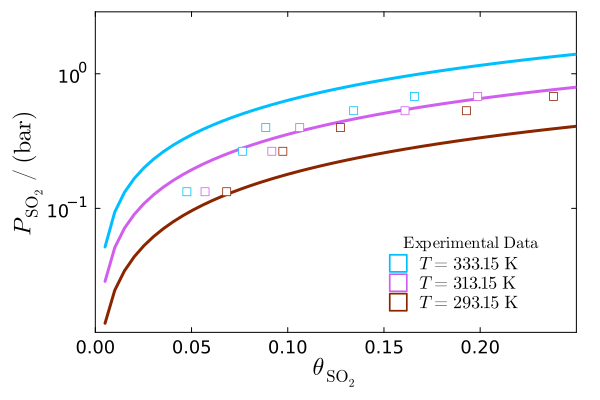

In [65]:
plt = plot(grid = :off, 
            framestyle = :box, 
            foreground_color_legend = nothing, 
            legend_font = font(12),
            xtickfont = font(12),
            ytickfont = font(12),
            yaxis = :log,
            legend =:bottomright,
            legendtitle = L"\mathrm{Experimental \ Data}",
            left_margin = 4mm,
            right_margin = 4mm,
            bottom_margin = 4mm,
            xguidefontsize=16,
            yguidefontsize=16,
            xlims = (0, 0.25))

plot!(plt, loadfil, partial3T3./1e5, 
    color = "deepskyblue1", 
    line = (:path, 3), 
    label = nothing)

plot!(plt, loadfil, partial3T2./1e5, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = nothing)

plot!(plt, loadfil, partial3T1./1e5, 
      color = "orangered4", 
      line = (:path, 3), 
      label = nothing)

plot!(plt, data3[11:15,4], data3[11:15, 2]./1e5, 
        seriestype = :scatter, 
        color = "white", 
        markerstrokecolor = "deepskyblue1",
        marker = :square,
        markerstrokewidth = 1,
        line = (:scatter, 3),
        label = L"T = 333.15 \ \mathrm{K}")

plot!(plt, data3[6:10,4], data3[6:10, 2]./1e5, 
        seriestype = :scatter, 
        color = "white", 
        markerstrokecolor = "mediumorchid2",
        marker = :square,
        markerstrokewidth = 1,
        line = (:scatter, 3),
        label = L"T = 313.15 \ \mathrm{K}")


plot!(plt, data3[1:5,4], data3[1:5, 2]./1e5, 
        seriestype = :scatter, 
        color = "white", 
        markerstrokecolor = "orangered4",
        marker = :square,
        markerstrokewidth = 1,
        line = (:scatter, 3),
        label = L"T = 293.15 \ \mathrm{K}")

xlabel!(plt, L"\theta\mathrm{_{SO_2}}")
ylabel!(plt, L"P\mathrm{_{SO_2} \ / \ (bar)}")
#annotate!(plt, 0.075, 2, text(L"\mathrm{Continous \ Lines: SAFT-\gamma \ Mie \ EoS}", 11, :black))
#savefig(plt, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\HiRecord_Figures&Photos\\SO2_Loading\\SO2_All_Temps_Loading_Subplot_log_no_annotation.png")

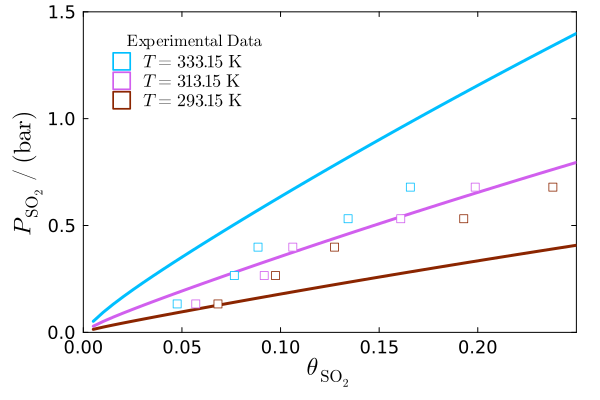

In [66]:
plt2 = plot(grid = :off, 
            framestyle = :box, 
            foreground_color_legend = nothing, 
            legend_font = font(12),
            xtickfont = font(12),
            ytickfont = font(12),
            legend =:topleft,
            legendtitle = L"\mathrm{Experimental \ Data}",
            left_margin = 4mm,
            right_margin = 4mm,
            bottom_margin = 4mm,
            xguidefontsize=16,
            yguidefontsize=16,
            xlims = (0, 0.25),
            ylims = (0, 1.5))

plot!(plt2, loadfil, partial3T3./1e5, 
    color = "deepskyblue1", 
    line = (:path, 3), 
    label = nothing)

plot!(plt2, loadfil, partial3T2./1e5, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = nothing)

plot!(plt2, loadfil, partial3T1./1e5, 
      color = "orangered4", 
      line = (:path, 3), 
      label = nothing)

plot!(plt2, data3[11:15,4], data3[11:15, 2]./1e5, 
        seriestype = :scatter, 
        color = "white", 
        markerstrokecolor = "deepskyblue1",
        marker = :square,
        markerstrokewidth = 1,
        line = (:scatter, 3),
        label = L"T = 333.15 \ \mathrm{K}")

plot!(plt2, data3[6:10,4], data3[6:10, 2]./1e5, 
        seriestype = :scatter, 
        color = "white", 
        markerstrokecolor = "mediumorchid2",
        marker = :square,
        markerstrokewidth = 1,
        line = (:scatter, 3),
        label = L"T = 313.15 \ \mathrm{K}")


plot!(plt2, data3[1:5,4], data3[1:5, 2]./1e5, 
        seriestype = :scatter, 
        color = "white", 
        markerstrokecolor = "orangered4",
        marker = :square,
        markerstrokewidth = 1,
        line = (:scatter, 3),
        label = L"T = 293.15 \ \mathrm{K}")

xlabel!(plt2, L"\theta\mathrm{_{SO_2}}")
ylabel!(plt2, L"P\mathrm{_{SO_2} \ / \ (bar)}")
#annotate!(plt2, 0.075, 2, text(L"\mathrm{Continous \ Lines: SAFT-\gamma \ Mie \ EoS}", 11, :black))
#savefig(plt2, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\HiRecord_Figures&Photos\\SO2_Loading\\SO2_All_Temps_Loading_Subplot_linear_annotation.png")

In [67]:
plt3 = plot(plt, plt2, layout = (2, 1), size = (600, 800))
savefig(plt3, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\HiRecord_Figures&Photos\\SO2_Loading\\SO2_All_Temps_Loading_Subplot_no_annotation.png")

"C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\HiRecord_Figures&Photos\\SO2_Loading\\SO2_All_Temps_Loading_Subplot_no_annotation.png"